# Genetic Algorithms for Parameter Optimization
## 1. Basic parts

First, we load necessary modules and set global parameter values.

In [1]:
# load modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True

from ea_operators import phenotypes
from ea_operators import initialize
from ea_operators import fitness
from ea_operators import crossover
from ea_operators import selection
from ea_utilities import objective_functions
from ea_utilities import visualize
from ea_algorithms.ga import ga

We initialize the first-generation population with random numbers and print it out.
Each row in the resulting matrix corresponds to one individual in the population.

Each individual encodes $N$ reals in $[a; b]$ as follows.
An individual of total length $N\cdot l$ is split into
$N$ parts of length $l$ each.
Each part represents one real in $[a; b]$:
* "all zeros" corresponds to $a$;
* "all ones" corresponds to $b$;
* everything else is mapped linearly onto reals in $[a; b]$.

For example, suppose we want to encode 3 parameters in $[-1; 2]$ and use $l = 5$ bits for each of them.
Then we can have a chromosome $10011\mid 01100\mid 01000$

Since $00000 \rightarrow -1$ and $11111 \rightarrow 2$, we compute
\begin{align*}
    10011 &\rightarrow \frac{19}{2^5 - 1} \cdot (2 - (-1)) + (-1) \approx 0.839\\
    01100 &\rightarrow \frac{12}{2^5 - 1} \cdot (2 - (-1)) + (-1) \approx 0.161\\
	01000 &\rightarrow \frac{8}{2^5 - 1} \cdot (2 - (-1)) + (-1) \approx -0.226
\end{align*}

To illustrate, let's compute fitness function
$f(\mathbf{x}) = x_1^2 + x_2^2 + x_3^2$.

In [2]:
# set random seed for reproducibility
np.random.seed(123)

# initializing the population
mu = 20  # population size
nvar = 3  # number of parameters
bits_num = 5  # bits to encode one parameter
a, b = -1, 2  # interval

population = initialize.initialize_real(
    mu, nvar, bits_num
)

print("Individuals:")
print(population)

# functions to pass into other functions
fitness_function = lambda x: np.sum(x**2, axis=1)
phenotype_function = lambda x: phenotypes.phenotype_real(
    x, a, b, nvar, bits_num
)

# the same can be achieved just by calling a fitness calculation function
# because it will also return individual phenotypes in the process
(individuals, fitnesses) = fitness.compute_fitness(
    population, phenotype_function, fitness_function
)

print("Individuals:")
print(individuals)

print("Their fitness values:")
print(fitnesses)

Individuals:
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]]
Individuals:
[[ 0.83870968

Now we can explore how $n$-point and uniform crossovers work.

For $n$-point crossovers, we generate $n$ random indexes, and
exchange the parts of the chromosome, alternating between two
parents.

For illustration purposes, we will use the first two individuals
to cross over.

In [3]:
child1, child2, crossover_points, crossover_indices =\
    crossover.crossover_n_point(
        population[0:2,], population[2:4,],
        prob_crossover=1, return_meta_data=True, n=2
    )

print("Crossovers occurred at positions {}".format(crossover_points))
print("Parents:")
print(population[0:2,])
print(population[2:4,])
print("Children:")
print(child1)
print(child2)

Crossovers occurred at positions [[0 2]
 [3 7]]
Parents:
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
Children:
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]


For uniform crossover, we flip a coin for each single gene
and decide whether it should go from parent 1 to child 1 and
from parent 2 to child 2, or from parent 1 to child 2 and
from parent 2 to child 1.

In [4]:
child1, child2, crossover_points, crossover_indices =\
    crossover.crossover_uniform(
        population[0:2,], population[2:4,],
        prob_crossover=1, return_meta_data=True
    )

print("Random numbers that decided what goes where: {}".format(crossover_points))
print("Parents:")
print(population[0:2,])
print(population[2:4,])
print("Children:")
print(child1)
print(child2)

Random numbers that decided what goes where: [[0.36357632 0.53995994 0.56810321 0.22546336 0.57214677 0.6609518
  0.29824539 0.41862686 0.45308892 0.93235066 0.58749375 0.94825237
  0.55603475 0.50056142 0.00353221]
 [0.48088904 0.927455   0.19836569 0.05209113 0.40677889 0.37239648
  0.85715306 0.02661112 0.92014923 0.680903   0.90422599 0.60752907
  0.81195331 0.33554387 0.34956623]]
Parents:
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
Children:
[[1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1.]]
[[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.]]


## 2. Minimizing test functions

Now we can combine everything in one big algorithm to be tried
on several test functions. The functions are taken from *An Analysis of the Behaviour of a Class of Genetic Adaptive
Systems* by K. A. De Jong (1975) and are commonly called *De Jong
functions*.

In [5]:
def plot_test_function(test_function, a, b):
    # create a grid of x and y values
    x = np.linspace(a, b, 100)
    y = np.linspace(a, b, 100)
    X, Y = np.meshgrid(x, y)
    xy_coordinates = np.column_stack((X.ravel(), Y.ravel()))

    # calculate z values
    result = test_function(xy_coordinates)
    Z = result.reshape(X.shape)

    # create a 3D figure with two subplots
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot the 3D surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # add labels and a color bar
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('')
    fig.colorbar(surf)

    # adjust the layout to prevent overlapping labels
    plt.tight_layout()

    # show the plot
    plt.show()

1) F1 function, also called the *spherical model*:

$$F_1(\mathbf{x}) = \sum_{i=1}^n x_i^2$$

It is continuous, convex, unimodal, quadratic,
symmetrical. So it is typically not hard to minimize.

Search is restricted to $[-5.12; 5.12]$ with step 0.01.

Minimum is of course at $\mathbf{x} = (0, \ldots, 0)^\top$
and equals $0$.

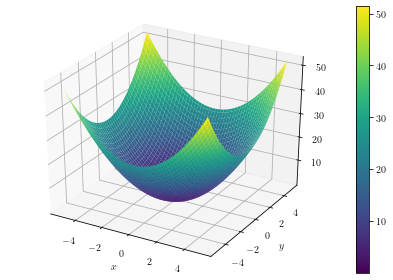

In [6]:
plot_test_function(objective_functions.F1, -5.12, 5.12)

2) F2 function (Rosenbrock function):

$$F_2(\mathbf{x}) = \sum_{i=1}^{n-1} \left(100(x_i^2 - x_{i+1})^2 + (1 - x_i)^2\right)$$

It is continuous, non-convex, unimodal, and
difficult because it has deep parabolic valleys
along the curves $x_{i+1} = x_i^2$.

Search is restricted to $[-2.048; 2.048]$ with step 0.001.

Minimum is attained at $\mathbf{x} = (1, \ldots, 1)^\top$
and equals $0$.


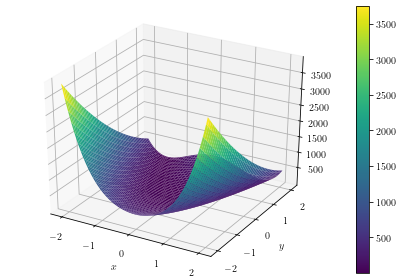

In [7]:
plot_test_function(objective_functions.F2, -2.048, 2.048)

3) F3 function:

$$F_3(\mathbf{x}) = \sum_{i=1}^n [x_i]$$

Here $[\cdot]$ represents closest integer from the left (floor function).

It is discontinuous, non-convex, unimodal, and
piecewise-constant.

Search is restricted to $[-5.12; 5.12]$ with step 0.01.

Minimum is attained at $\mathbf{x} = (-5.12, \ldots, -5.12)^\top$
and equals $-6n$.

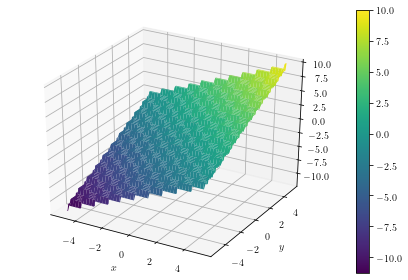

In [8]:
plot_test_function(objective_functions.F3, -5.12, 5.12)

4) F4 function:

$$F_4(\mathbf{x}) = \sum_{i=1}^n i x_i^4 + N(0, 1)$$

(This is for $n = 30$. For other $n$, standard deviation of random
normals is chosen heuristically not to be too large.)
It is continuous, convex, unimodal, and
quartic. Most importantly, it is *stochastic*, in the sense
that on *each evaluation* it yields slightly different
results.

Search is restricted to $[-1.28; 1.28]$ with step 0.01.

Minimum (deterministic part) is of course at $\mathbf{x} = (0, \ldots, 0)^\top$
and equals $0$.

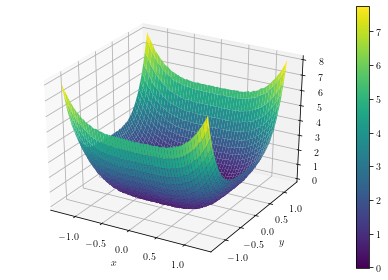

In [9]:
plot_test_function(objective_functions.F4, -1.28, 1.28)

5) F5 function:

$$F_5(x_1, x_2) = \left(\frac{1}{500} + \sum_{j=1}^{25} \frac{1}{f_j(x_1, x_2)}\right)^{-1}\;,$$
where
$$f_j(x_1, x_2) = j + \sum_{i=1}^2 (x_i - a_{ij})^6\;,$$
where

$\mathbf{a} =  \begin{pmatrix}
-32 & -16 & 0 & 16 & 32 & -32 & -16 & \ldots & 0 & 16 & 32\\
-32 & -32 & -32 & -32 & -32 & -16 & -16 & \ldots 32 & 32 & 32
\end{pmatrix}$

It is continuous, non-convex, non-quadratic, and multimodal,
making it especially hard to optimize.

Search is restricted to $[-65.536; 65.536]$ with step 0.001.

Minimum is attained at (approximately) $(-32, -32)^\top$
and equals $1$. (Pay attention that each "column" is of different height.)


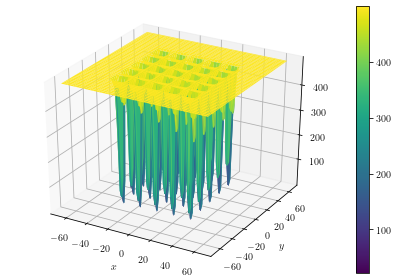

In [10]:
plot_test_function(objective_functions.F5, -65.536, 65.536)

First let's see how a basic GA with the simple crossover tackles
these problems, and how to choose parameters to improve its performance.

With F1 function, everything is easy.

KeyboardInterrupt: 

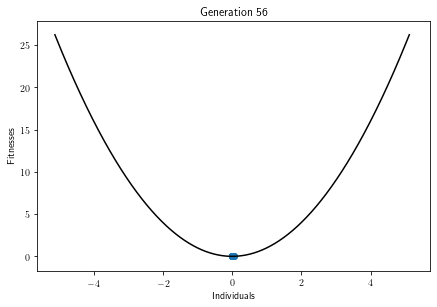

In [6]:
np.random.seed(123)
population, individuals, fitnesses,\
generation_final, success, function_evals =\
    ga(objective_function=objective_functions.F1,
       nvar=1, a=-5.12, b=5.12, bits_num=32,
       mu=50,
       crossover_function=crossover.crossover_uniform,
       prob_crossover=1, prob_mutation=0.001,
       generations_count=2000,
       optimum_value=0, precision=1e-8,
       do_draw_population=True,  # feel free to turn this on or off
       do_print=False)  # feel free to turn this on or off

We can even compare how different $n$-point and uniform crossovers influence
the algorithm performance. To make things more realistic, we will
also increase dimensionality of the problem.

In [7]:
T = 5
random_seed = 123
nvar = 5  # already for nvar = 5 we have bad results
mu = 50
print_iteration_number = True
prob_mutation = 0.001

ga_function_1_point =\
    lambda: ga(objective_function=objective_functions.F1,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_one_point,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("1-point crossover:")
visualize.report_average_ga_progress(
    ga_function_1_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_2_point =\
    lambda: ga(objective_function=objective_functions.F1,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 2}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("2-point crossover:")
visualize.report_average_ga_progress(
    ga_function_2_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_10_point =\
    lambda: ga(objective_function=objective_functions.F1,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 10}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("10-point crossover:")
visualize.report_average_ga_progress(
    ga_function_10_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_uniform =\
    lambda: ga(objective_function=objective_functions.F1,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_uniform,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Uniform crossover:")
visualize.report_average_ga_progress(
    ga_function_uniform, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

1-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 0.0
Mean function evaluations: 100000.000
Std of function evaluations: 0.000
Mean final generation: 2000.000
Std of final generations: 0.000
Mean of best fitnesses: 0.00000834
The best fitness ever: 0.00000302

2-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 0.0
Mean function evaluations: 100000.000
Std of function evaluations: 0.000
Mean final generation: 2000.000
Std of final generations: 0.000
Mean of best fitnesses: 0.00000710
The best fitness ever: 0.00000196

10-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 0.0
Mean function evaluations: 100000.000
Std of function evaluations: 0.000
Mean final generation: 2000.000
Std of final generations: 0.000
Mean of best 

Now let's try the F2 function. As we can see, it doesn't work very
well. Feel free to try different crossovers and other parameters.

In [8]:
T = 5
random_seed = 123
print_iteration_number = True

ga_function =\
    lambda: ga(objective_function=objective_functions.F2,
               nvar=2, a=-2.048, b=2.048, bits_num=32,
               mu=50,
               crossover_function=crossover.crossover_one_point,
               prob_crossover=1, prob_mutation=0.05,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

visualize.report_average_ga_progress(
    ga_function, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 0.0
Mean function evaluations: 100000.000
Std of function evaluations: 0.000
Mean final generation: 2000.000
Std of final generations: 0.000
Mean of best fitnesses: 0.00016803
The best fitness ever: 0.00003183



Now let's try the F3 function.

Finished because the perfect solution has been found!
The final generation was 35.


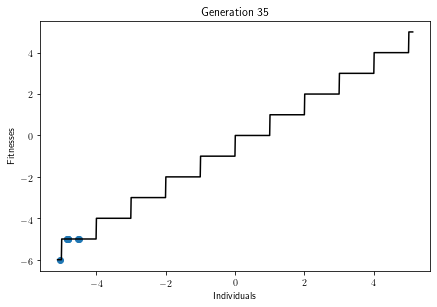

In [3]:
np.random.seed(123)
nvar=1
population, individuals, fitnesses,\
generation_final, success, function_evals =\
    ga(objective_function=objective_functions.F3,
       nvar=nvar, a=-5.12, b=5.12, bits_num=32,
       mu=8,
       crossover_function=crossover.crossover_one_point,
       prob_crossover=1, prob_mutation=0.001,
       generations_count=2000,
       optimum_value=-6*nvar, precision=1e-8,
       do_draw_population=True,  # feel free to turn this on or off
       do_print=False)  # feel free to turn this on or off

We can compare how different $n$-point and uniform crossovers influence
the algorithm performance.

In [9]:
T = 5
random_seed = 123
nvar = 5
mu = 50
print_iteration_number = True
prob_mutation = 0.001

ga_function_1_point =\
    lambda: ga(objective_function=objective_functions.F3,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_one_point,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=-6*nvar, precision=1e-8,
               suppress_output=True, do_print=False)

print("1-point crossover:")
visualize.report_average_ga_progress(
    ga_function_1_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_2_point =\
    lambda: ga(objective_function=objective_functions.F3,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 2}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=-6*nvar, precision=1e-8,
               suppress_output=True, do_print=False)

print("2-point crossover:")
visualize.report_average_ga_progress(
    ga_function_2_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_10_point =\
    lambda: ga(objective_function=objective_functions.F3,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 10}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=-6*nvar, precision=1e-8,
               suppress_output=True, do_print=False)

print("10-point crossover:")
visualize.report_average_ga_progress(
    ga_function_10_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_uniform =\
    lambda: ga(objective_function=objective_functions.F3,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_uniform,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=-6*nvar, precision=1e-8,
               suppress_output=True, do_print=False)

print("Uniform crossover:")
visualize.report_average_ga_progress(
    ga_function_uniform, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

1-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 5.0
Mean function evaluations: 6400.000
Std of function evaluations: 5010.988
Mean final generation: 128.000
Std of final generations: 100.220
Mean of best fitnesses: -30.00000000
The best fitness ever: -30.00000000

2-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 5.0
Mean function evaluations: 8240.000
Std of function evaluations: 4876.525
Mean final generation: 164.800
Std of final generations: 97.531
Mean of best fitnesses: -30.00000000
The best fitness ever: -30.00000000

10-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 5.0
Mean function evaluations: 1350.000
Std of function evaluations: 150.000
Mean final generation: 27.000
Std of final generations: 3.000
Mean

Now let's try the F4 function. It works (surprisingly) well for
$n = 1$, but much worse for higher dimensions.

In [6]:
np.random.seed(123)
nvar = 1
population, individuals, fitnesses,\
generation_final, success, function_evals =\
    ga(objective_function=objective_functions.F4,
       nvar=nvar, a=-1.28, b=1.28, bits_num=32,
       mu=50,
       crossover_function=crossover.crossover_one_point,
       prob_crossover=1, prob_mutation=0.001,
       generations_count=2000,
       optimum_value=0, precision=1e-8,
       do_draw_population=False,   # feel free to turn this on or off
       do_print=False)  # feel free to turn this on or off

Finished because the perfect solution has been found!
The final generation was 84.


We can compare how different $n$-point and uniform crossovers influence
the algorithm performance.

In [19]:
T = 5
random_seed = 123
nvar = 1
mu = 50
print_iteration_number = True
prob_mutation = 0.001

ga_function_1_point =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_one_point,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("1-point crossover:")
visualize.report_average_ga_progress(
    ga_function_1_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_2_point =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 2}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("2-point crossover:")
visualize.report_average_ga_progress(
    ga_function_2_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_10_point =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 10}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("10-point crossover:")
visualize.report_average_ga_progress(
    ga_function_10_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_uniform =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_uniform,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Uniform crossover:")
visualize.report_average_ga_progress(
    ga_function_uniform, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

1-point crossover:
Iteration number 1


IndexError: index 1462 is out of bounds for axis 0 with size 50

Now let's try the F5 function.

Finished because the perfect solution has been found!
The final generation was 25.


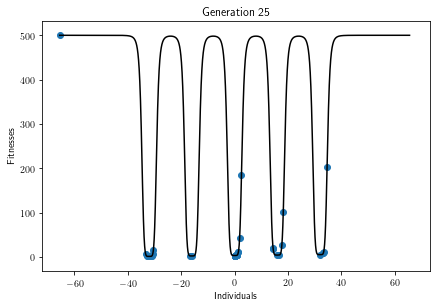

In [7]:
np.random.seed(123)
nvar=1
population, individuals, fitnesses,\
generation_final, success, function_evals =\
    ga(objective_function=objective_functions.F5,
       nvar=nvar, a=-65.536, b=65.536, bits_num=32,
       mu=50,
       crossover_function=crossover.crossover_one_point,
       prob_crossover=1, prob_mutation=0.005,
       generations_count=2000,
       optimum_value=0.99800393, precision=1e-8,
       do_draw_population=True,   # feel free to turn this on or off
       do_print=False)  # feel free to turn this on or off

We can compare how different $n$-point and uniform crossovers influence
the algorithm performance.

In [21]:
T = 5
random_seed = 123
nvar = 2
mu = 50
print_iteration_number = True
prob_mutation = 0.001

ga_function_1_point =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=nvar, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_one_point,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("1-point crossover:")
visualize.report_average_ga_progress(
    ga_function_1_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_2_point =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=nvar, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 2}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("2-point crossover:")
visualize.report_average_ga_progress(
    ga_function_2_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_10_point =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=nvar, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=(crossover.crossover_n_point, {"n": 10}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("10-point crossover:")
visualize.report_average_ga_progress(
    ga_function_10_point, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_uniform =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=nvar, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_uniform,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("Uniform crossover:")
visualize.report_average_ga_progress(
    ga_function_uniform, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

1-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 2.0
Mean function evaluations: 64570.000
Std of function evaluations: 48515.070
Mean final generation: 1291.400
Std of final generations: 970.301
Mean of best fitnesses: 1.43795564
The best fitness ever: 0.99800384

2-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 0.0
Mean function evaluations: 100000.000
Std of function evaluations: 0.000
Mean final generation: 2000.000
Std of final generations: 0.000
Mean of best fitnesses: 3.42098097
The best fitness ever: 0.99801249

10-point crossover:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 1.0
Mean function evaluations: 80210.000
Std of function evaluations: 44251.785
Mean final generation: 1604.200
Std of final generations: 885.036
Mea

## 3. Other Selection Methods

Now we can see how the choice of selection influences GA performance.
In particular, we will look only at how the **tournament selection**
compares to the roulette wheel selection. According to this method,
$q$ individuals are selected at random, and the best among them is
selected as a prospective parent. This selection continues until
the required number of parents has been selected. Parameter $q$
is commonly called *tournament size*.

First, let's take a look at F1 function. As we recall, basic GA
was not very efficient at minimizing already when there were
around 5 arguments.

In [24]:
T = 5
random_seed = 123
nvar = 5  # with tournament selection, nvar = 5 is very easy
          # and even up to nvar = 50 works well
print_iteration_number = True
mu = 50
prob_mutation = 0.001
crossover_function = crossover.crossover_one_point
q = 15

ga_function_roulette =\
    lambda: ga(objective_function=objective_functions.F1,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection.selection_roulette_wheel,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Roulette wheel selection:")
visualize.report_average_ga_progress(
    ga_function_roulette, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_tournament =\
    lambda: ga(objective_function=objective_functions.F1,
               nvar=nvar, a=-5.12, b=5.12, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=(selection.selection_tournament,
                                   {"q": q}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Tournament selection:")
visualize.report_average_ga_progress(
    ga_function_tournament, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Tournament selection:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 5.0
Mean function evaluations: 30940.000
Std of function evaluations: 3990.520
Mean final generation: 618.800
Std of final generations: 79.810
Mean of best fitnesses: 0.00000001
The best fitness ever: 0.00000000



Now let's take a look at F2. As we recall, roulette wheel selection
was not at all successful. Note unusual selection of some parameters
(otherwise results are much worse).

In [25]:
T = 5
random_seed = 123
print_iteration_number = True
mu = 50

ga_function =\
    lambda: ga(objective_function=objective_functions.F2,
               nvar=2, a=-2.048, b=2.048, bits_num=32,
               mu=mu,
               crossover_function=crossover.crossover_uniform,
               selection_function=(selection.selection_tournament,
                                   {"q": 15}),
               prob_crossover=1, prob_mutation=0.05,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

visualize.report_average_ga_progress(
    ga_function, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 1.0
Mean function evaluations: 93640.000
Std of function evaluations: 14221.392
Mean final generation: 1872.800
Std of final generations: 284.428
Mean of best fitnesses: 0.01168957
The best fitness ever: 0.00000000



We will not show F3 because even roulette wheel selection was not
particularly bad, and clearly tournament selection must be
even better.

We will instead take a look at F4. Earlier, we found that performance
was mixed for 1 argument, and it was a lost cause for 30 arguments
(as was originally intended by De Jong). Note unusual selection of some parameters
(otherwise results are much worse).

In [26]:
T = 5
random_seed = 123
nvar = 30
print_iteration_number = True
crossover_function = crossover.crossover_one_point
prob_mutation = 0.001

ga_function_roulette =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=50,
               crossover_function=crossover_function,
               selection_function=selection.selection_roulette_wheel,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Roulette wheel selection:")
visualize.report_average_ga_progress(
    ga_function_roulette, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_tournament =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=70,
               crossover_function=crossover_function,
               selection_function=(selection.selection_tournament,
                                   {"q": 15}),
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Tournament selection:")
visualize.report_average_ga_progress(
    ga_function_tournament, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Roulette wheel selection:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5


KeyboardInterrupt: 

Finally, we can take a look and compare performance on F5.
The main issue in two dimensions is that GA is prone to getting
stuck in local minima. We will discuss what to do with this
below.

In [27]:
T = 5
random_seed = 123
print_iteration_number = True

ga_function =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=50,
               crossover_function=crossover.crossover_one_point,
               selection_function=(selection.selection_tournament,
                                   {"q": 15}),
               prob_crossover=1, prob_mutation=0.001,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

visualize.report_average_ga_progress(
    ga_function, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 0.0
Mean function evaluations: 25000.000
Std of function evaluations: 0.000
Mean final generation: 500.000
Std of final generations: 0.000
Mean of best fitnesses: 3.64666634
The best fitness ever: 0.99828418



## 4. Steady-State Genetic Algorithm

Up to this point, we assumed that on each generation, we create
as many offspring as there are individuals (namely, $\mu$), so that
the whole population is replaced. This is the so called *generational
model* of a population. In the *steady-state model*, we always replace
(approximately) $G \cdot \mu$ individuals.

A separate question is how to select individuals to be replaced.
For simplicity, we will focus only on two alternatives:
- stochastically select individuals to be replaced;
- replace the worst individuals.

We will test performance only on F2, F4, and F5, which were hard
to optimize before.

First, for F2, we can see some improvement, for both
versions of the steady-state model.

In [31]:
T = 5
random_seed = 123
print_iteration_number = True
crossover_function = crossover.crossover_uniform
selection_function = (selection.selection_tournament, {"q": 15})
prob_mutation = 0.05
mu = 50
children_count = 40

ga_function_generational =\
    lambda: ga(objective_function=objective_functions.F2,
               nvar=2, a=-2.048, b=2.048, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Generational model:")
visualize.report_average_ga_progress(
    ga_function_generational, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_steady_state_stochastic =\
    lambda: ga(objective_function=objective_functions.F2,
               nvar=2, a=-2.048, b=2.048, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=False,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Steady-state model, stochastic:")
visualize.report_average_ga_progress(
    ga_function_steady_state_stochastic, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_steady_state_deterministic =\
    lambda: ga(objective_function=objective_functions.F2,
               nvar=2, a=-2.048, b=2.048, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=True,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Steady-state model, deterministic:")
visualize.report_average_ga_progress(
    ga_function_steady_state_deterministic, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Steady-state model, deterministic:
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Total number of successes: 1.0
Mean function evaluations: 42487.200
Std of function evaluations: 21324.933
Mean final generation: 1633.200
Std of final generations: 820.190
Mean of best fitnesses: 0.00382970
The best fitness ever: 0.00000000



For F4, we (still) don't see much improvement, because the function
is actually very hard to optimize (stochastic).

In [ ]:
T = 5
random_seed = 123
print_iteration_number = True
crossover_function = crossover.crossover_uniform
selection_function = (selection.selection_tournament, {"q": 15})
prob_mutation = 0.001
nvar = 5  # for nvar = 30, still doesn't work that well
mu = 70
children_count = 60

ga_function_generational =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Generational model:")
visualize.report_average_ga_progress(
    ga_function_generational, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_steady_state_stochastic =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=False,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Steady-state model, stochastic:")
visualize.report_average_ga_progress(
    ga_function_steady_state_stochastic, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_steady_state_deterministic =\
    lambda: ga(objective_function=objective_functions.F4,
               nvar=nvar, a=-1.28, b=1.28, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=True,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=2000,
               optimum_value=0, precision=1e-8,
               suppress_output=True, do_print=False)

print("Steady-state model, deterministic:")
visualize.report_average_ga_progress(
    ga_function_steady_state_deterministic, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

Finally, for F5, we also don't see much improvement.
We still occasionally get stuck in local minima.

In [ ]:
T = 5
random_seed = 123
print_iteration_number = True
crossover_function = crossover.crossover_one_point
selection_function = (selection.selection_tournament, {"q": 15})
prob_mutation = 0.01
mu = 50
children_count = 40

ga_function_generational =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("Generational model:")
visualize.report_average_ga_progress(
    ga_function_generational, T=T, random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_steady_state_stochastic =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=False,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("Steady-state model, stochastic:")
visualize.report_average_ga_progress(
    ga_function_steady_state_stochastic, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_steady_state_deterministic =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=True,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("Steady-state model, deterministic:")
visualize.report_average_ga_progress(
    ga_function_steady_state_deterministic, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

## 5. Sharing

Now let us see how sharing (as an explicit way of handling
multiobjective problems) helps with optimizing F5.

First, let us see how it looks like graphically

In [ ]:
np.random.seed(123)

population, individuals, fitnesses,\
generation_final, success, fitness_evals =\
    ga(objective_function=objective_functions.F5,
       nvar=1, a=-65.536, b=65.536, bits_num=32,
       mu=50,
       crossover_function=crossover.crossover_one_point,
       prob_crossover=1, prob_mutation=0.005,
       generations_count=2000,
       optimum_value=0.99800393, precision=1e-8,
       do_draw_population=True,   # feel free to turn this on or off
       do_print=False,
       do_derate=True)  # feel free to turn this on or off

Now we can perform statistical comparison. Notice that for
$n = 2$ we increased population size to $\mu = 100$ because
we need more individuals to make subpopulations large enough.
If $\mu$ is to small, introduction of sharing won't help much.

In [ ]:
T = 5
random_seed = 123
print_iteration_number = True
crossover_function = crossover.crossover_one_point
selection_function = (selection.selection_tournament, {"q": 15})
prob_mutation = 0.01
mu = 100
children_count = 50

ga_function_generational =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

ga_function_wo_sharing =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=True,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False)

print("Without sharing:")
visualize.report_average_ga_progress(
    ga_function_wo_sharing, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)

ga_function_w_sharing =\
    lambda: ga(objective_function=objective_functions.F5,
               nvar=2, a=-65.536, b=65.536, bits_num=32,
               mu=mu,
               crossover_function=crossover_function,
               selection_function=selection_function,
               children_count=children_count,
               replace_worst=True,
               prob_crossover=1, prob_mutation=prob_mutation,
               generations_count=500,
               optimum_value=0.9980038388, precision=1e-8,
               suppress_output=True, do_print=False, do_derate=True)

print("With sharing:")
visualize.report_average_ga_progress(
    ga_function_w_sharing, T=T,
    random_seed=random_seed,
    print_iteration_number=print_iteration_number
)